In [1]:
import os
import sys
import pandas as pd
from pyspark import SparkContext, sql, SparkConf
import nltk
import re
from datetime import datetime
from itertools import cycle, islice
import __builtin__
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import pickle

#import pyspark.sql as sparksql
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row
from collections import Counter
import seaborn as sb
%matplotlib inline

#-------------------------------
# Importing from other folders, appending the path
sys.path.append('../')
from spark_sessions import start_session, stop_session
print "all imported."

all imported.


/Users/Ahmed/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [33]:
spark_configs = (SparkConf()\
            .setAppName("experiment-airbnb")\
            .set("spark.executor.instances", "10")\
            .set("spark.executor.cores", 2)\
            .set("spark.dynamicAllocation.enabled", "false")\
            .set("spark.shuffle.service.enabled", "false")\
            .set("spark.executor.memory", "500MB"))
#pickle.dump( spark_configs, open( "sparks.txt", "wb" ) )

In [34]:
#----------------
def spark_session(version):
    if version == 0:
        conf = spark_configs
        return conf
    
    elif version == 1:
        spark = SparkSession.builder \
            .master("yarn") \
            .appName("experiment-airbnb") \
            .enableHiveSupport() \
            .getOrCreate()

        return spark

In [35]:
#----------------
def spark_context_sql(sample):
    # Creating "pyspark.sql.context.SQLContext object"
    sqlContext = SQLContext(spark_session(version=1))
    data = sqlContext.read.load(sample,
                    format='com.databricks.spark.csv', 
                    header='true', 
                    inferSchema='true').cache()
        
    return data

def spark_context_txt(sample):
    # Creating "pyspark.context.SparkContext object"
    conf = spark_session(version=0)
    sc = SparkContext.getOrCreate(conf = conf)
    data = sc.textFile(sample)
    #print 'type of context for session v 0:', sc
    
    return data

In [36]:
#----------------
def structure_field(key, item): # item = StringType() ...
    key = str
    item = str
    structure = []
    structure.append(StructField(key, item, True))
        
    return structure

In [37]:
def spark_framing(data, schema):
    # take the schema and convert it to a spark DF
    spark_df = data.map(lambda x: (x, )).toDF(schema)
    
    return spark_df
    

In [38]:
def panda_framing(sample):
    # Frame the data with panda
    #_panda_framed = pd.read_csv(sample)
    #panda_framed = pd.DataFrame(_panda_framed)
    data = spark_context_sql(sample)
    panda_df = data.sample(False, 0.5, 83).toPandas()
    print panda_df.head()
    
    return panda_df

In [39]:
#----------------
def spark_schema_v0(sample):
    data = spark_context_sql(sample) # we need this to create the keys (data types)
    _keys = data.take(2)
    
    _data = spark_context_txt(sample) # we need this to create the schema
    schemaString = _data.first().replace('"','')
    _schema = schemaString.split(',')# Creating a schema
    headers = _data.filter(lambda l: "_id" in l) # Headers needs to be an RDD - the string we constructed above will not do the job
    headers.collect()
    _spark_data = _data.subtract(headers)
    spark_data= _spark_data.map(lambda l: l.split(","))

    
    print "Found %d columns in your data file \n" % len(_keys[0]) 
    _types = []
    fields = []
    #schem = schemaString.split(',')
    print "Followings are the details of your schema:"
    print "------------------------------------------"
    for key in range(len(_keys[1])) or (type(_keys[1][key]) == None):   
        if (type(_keys[1][key]) == int):
            data_type = IntegerType()
            str_struct = StructField(_schema[key], data_type, True)
            fields.append(str_struct)
            #_types.append((_schema[key], data_type))
            print 'key:', '"'+_schema[key]+'",',',', ' value:', _keys[1][key],',', ' data type:', data_type #, ' value:', _keys[0][key], 
        
        elif (type(_keys[1][key]) == float):
            data_type = FloatType()
            str_struct = StructField(_schema[key], data_type, True)
            fields.append(str_struct)
            #_types.append((_schema[key], data_type))
            print 'key:', '"'+_schema[key]+'",',',',' value:', _keys[1][key],',', ' data type:', data_type #, ' value:', _keys[0][key],
        
        elif (type(_keys[1][key]) == unicode) or (type(_keys[0][key]) == str):
            data_type = StringType()
            str_struct = StructField(_schema[key], data_type, True)
            fields.append(str_struct)
            #_types.append((_schema[key], data_type))
            print 'key:', '"'+_schema[key]+'",',',', ' value:', _keys[1][key], ',', 'data type:', data_type
        
        else:
            data_type = StringType()#TimestampType()
            str_struct = StructField(_schema[key], data_type, True)
            fields.append(str_struct)
            #_types.append((_schema[key], data_type))
            print 'key:', '"'+_schema[key]+'",',',', ' value:', _keys[1][key], ',', 'data type:', data_type
    
    print "------------------------------------------"
    print "Your schema's 'StructField' are:"
    for x in fields:
        print x
        pickle.dump( x, open( "sparks.txt", "ab" ) )
    
    print "------------------------------------------"

    
    # Creating the spark DataFrame:
    conf = spark_session(version=0)
    sc = SparkContext.getOrCreate(conf = conf)
    _spark_data.map(lambda l: tuple(l[:1]) + tuple(l[1].split(','))).map(lambda x: x.split('\t'))
    #print _spark_data
    #rdd = sc.parallelize(_spark_data.map( lambda elem: list(elem)))
    #.map(lambda p: (p[0], p[1].strip()))
    
    schema = StructType(fields)
    spark_df = spark_framing(_spark_data, schema)
    
    return spark_df


In [40]:
sample = "/Users/Ahmed/Documents/Data-Mining/Hadoop/Spark/PySpark/data/airbnb/listings.csv"
df = spark_schema_v0(sample)

Found 16 columns in your data file 

Followings are the details of your schema:
------------------------------------------
key: "id", ,  value: 4882829 , data type: StringType
key: "name", ,  value: Private room in Inner Richmond , data type: StringType
key: "host_id", ,  value: 25118670 , data type: StringType
key: "host_name", ,  value: Coraly , data type: StringType
key: "neighbourhood_group", ,  value: None , data type: StringType
key: "neighbourhood", ,  value: Inner Richmond , data type: StringType
key: "latitude", ,  value: 37.77899256458584 , data type: StringType
key: "longitude", ,  value: -122.46211057 ,  data type: FloatType
key: "room_type", ,  value: Private room , data type: StringType
key: "price", ,  value: 89 , data type: StringType
key: "minimum_nights", ,  value: 2 ,  data type: IntegerType
key: "number_of_reviews", ,  value: 1 ,  data type: IntegerType
key: "last_review", ,  value: 2015-04-22 , data type: StringType
key: "reviews_per_month", ,  value: 1 , data type

In [41]:
panda_df = panda_framing(sample)
print '\n \n', "DataFrame before replacing NaNs"
print '-'*30
print panda_df.isnull().any(), '\n \n'
#listt = panda_df.columns[panda_df.isnull().any()].tolist()
panda_df.fillna(0, inplace=True)

print 'DataFrame after replacing NaNs with zeros'
print '-'*40
print panda_df.isnull().any()

print '\n \n', "Length of DataFrame: %d" %len(panda_df)

        id                                 name   host_id   host_name  \
0   295240  Luxury Apartment Oasis w/ Hot Tub     1525192  Kristoffer   
1  4882829       Private room in Inner Richmond  25118670      Coraly   
2  4850420          Edge of SOMA + the Mission    1358761       Kelly   
3  5068275               Huge & Sunny 1BR Loft     350767     Michael   
4  2315086  Pacific Heights, 2 rooms & parking!  11804983       Renee   

  neighbourhood_group        neighbourhood            latitude   longitude  \
0                None  Castro/Upper Market    37.7626741714481 -122.439195   
1                None       Inner Richmond   37.77899256458584 -122.462111   
2                None      South of Market  37.771447300839284 -122.414782   
3                None         Potrero Hill   37.75944905468306 -122.389447   
4                None      Pacific Heights   37.78757176562912 -122.444948   

         room_type price  minimum_nights  number_of_reviews last_review  \
0  Entire home/ap

### Data insights

/Users/Ahmed/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


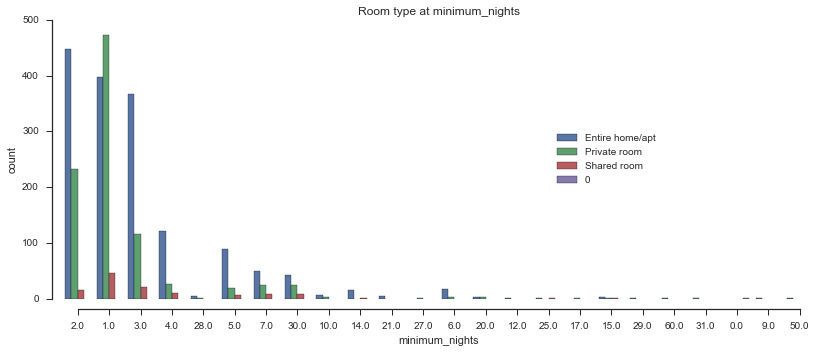

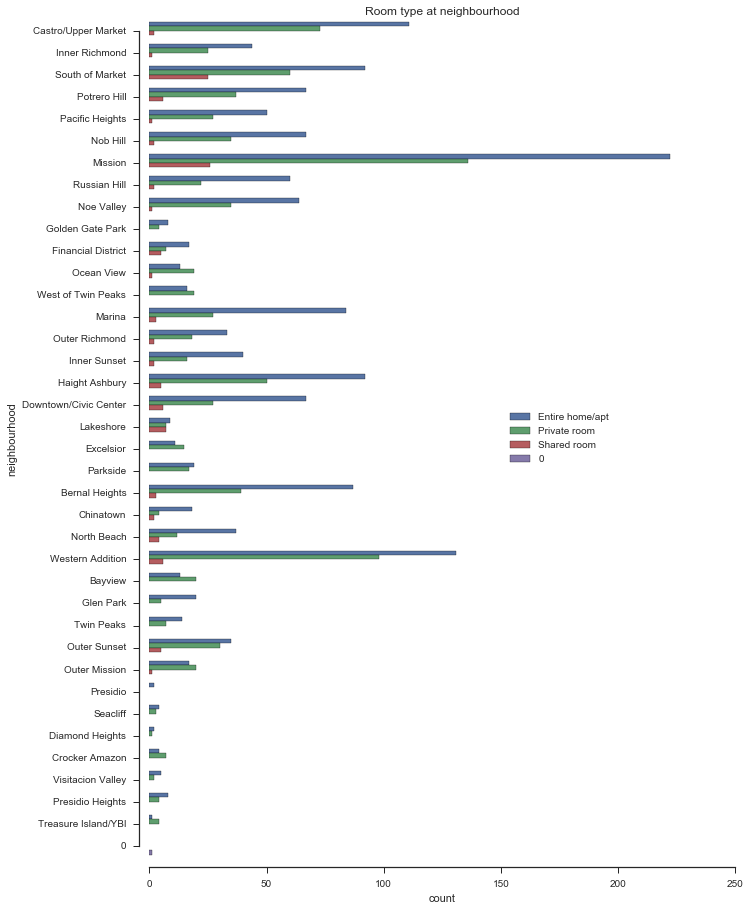

In [42]:
sb.set_style("white")
sb.set_style('ticks')

fig, ax = plt.subplots()
fig.set_size_inches(13.5, 5.0)

sb.countplot(x='minimum_nights',hue="room_type", data=panda_df)
ax.legend_.remove()
ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.5), ncol=1)
sb.despine(offset=10, trim=True)
sb.plt.title('Room type at minimum_nights')
sb.despine()

#-------------------------------------------
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 15.0)

sb.countplot(y='neighbourhood',hue="room_type", data=panda_df)
ax.legend_.remove()
ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.5), ncol=1)
sb.despine(offset=10, trim=True)
sb.plt.title('Room type at neighbourhood')
sb.despine()

plt.show()

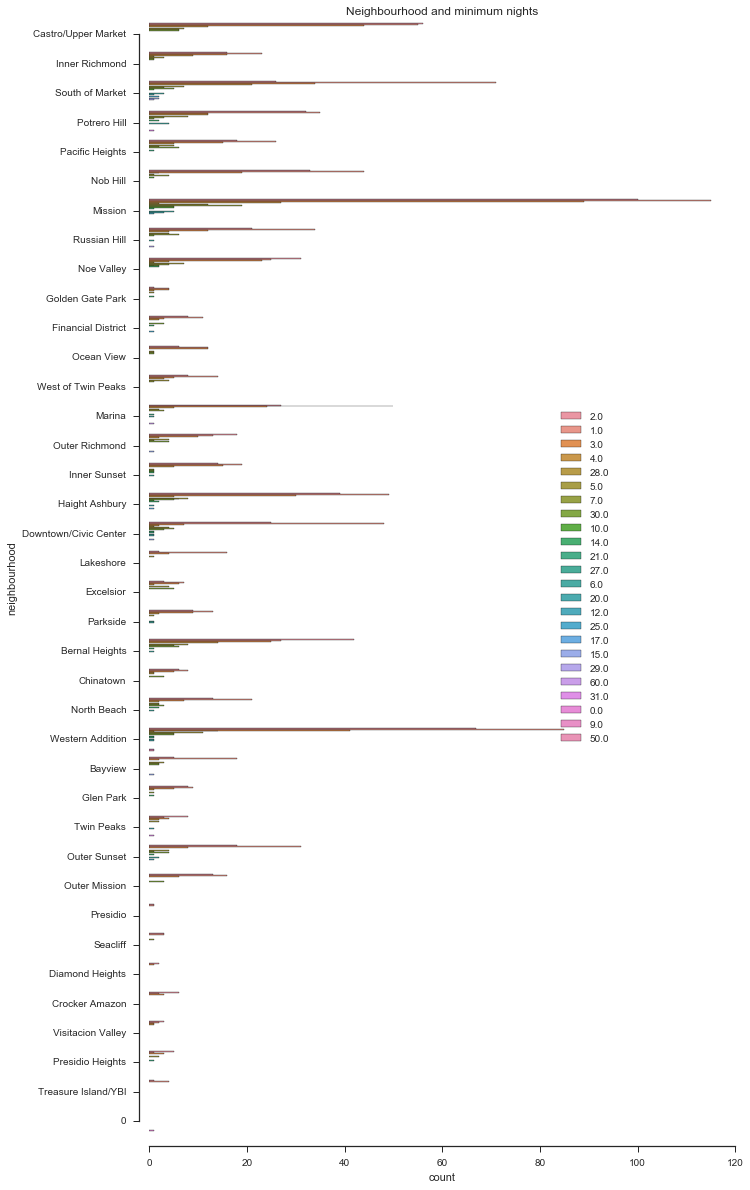

In [102]:
#-------------------------------------------
fig, ax = plt.subplots()
fig.set_size_inches(10.5, 20.0)

sb.countplot(y='neighbourhood',hue="minimum_nights", data=panda_df)
ax.legend_.remove()
ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.5), ncol=1)
sb.despine(offset=10, trim=True)
sb.plt.title('Neighbourhood and minimum nights')
sb.despine()
plt.show()

In [106]:
# #-------------------------------------------
# fig, ax = plt.subplots()
# fig.set_size_inches(10.5, 20.0)

# sb.countplot(y='neighbourhood',hue="number_of_reviews", data=panda_df)
# ax.legend_.remove()
# ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.5), ncol=1)
# sb.despine(offset=10, trim=True)
# sb.plt.title('Neighbourhood and minimum nights')
# sb.despine()
# plt.show()

In [104]:

# fig = plt.figure()
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# #fig, ax = plt.subplots()
# # the size of A4 paper
# fig.set_size_inches(15.0, 5.0)
# sb.despine(offset=10, trim=True)
# sb.countplot(x='minimum_nights', hue="room_type", data=panda_df, ax=ax1)
# sb.countplot(x="room_type", data=panda_df, ax=ax2)
# ax1.legend_.remove()
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
# ax1.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
# #plt.close(g.fig)
# plt.show()

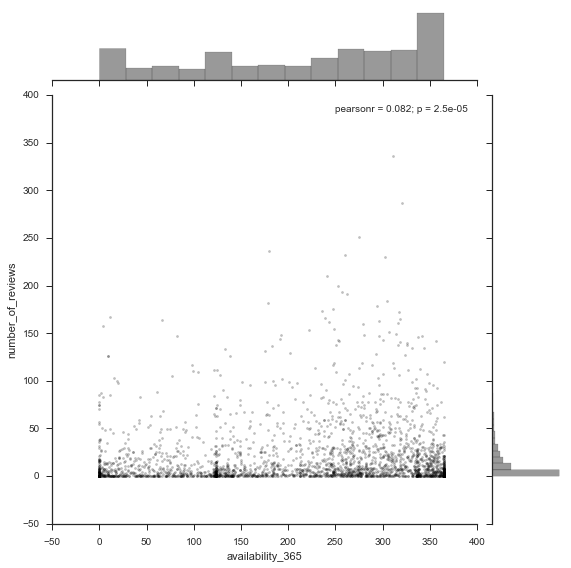

In [109]:
sb.jointplot(x='availability_365', y='number_of_reviews', data=panda_df, size=8, alpha=.25,
              color='k', marker='.')

In [51]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(panda_df.neighbourhood)
rt_dummies = pd.get_dummies(panda_df.room_type)

# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((panda_df.drop(['neighbourhood', 'room_type'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)
panda_df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,295240,Luxury Apartment Oasis w/ Hot Tub,1525192,Kristoffer,0,Castro/Upper Market,37.7626741714481,-122.439195,Entire home/apt,250,2.0,23.0,2015-04-01,0.6,1.0,215.0
1,4882829,Private room in Inner Richmond,25118670,Coraly,0,Inner Richmond,37.77899256458584,-122.462111,Private room,89,2.0,1.0,2015-04-22,1,1.0,111.0
2,4850420,Edge of SOMA + the Mission,1358761,Kelly,0,South of Market,37.771447300839284,-122.414782,Private room,164,1.0,0.0,0,0,1.0,111.0
3,5068275,Huge & Sunny 1BR Loft,350767,Michael,0,Potrero Hill,37.75944905468306,-122.389447,Entire home/apt,185,2.0,5.0,2015-03-29,1.7,1.0,9.0
4,2315086,"Pacific Heights, 2 rooms & parking!",11804983,Renee,0,Pacific Heights,37.78757176562912,-122.444948,Private room,135,3.0,55.0,2015-04-26,3.9,1.0,207.0


In [44]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics

/Users/Ahmed/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Ahmed/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


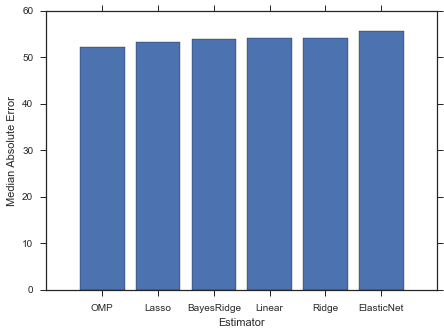

In [63]:
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop([
    'price', 'last_review','host_name', 'name'], 
    axis=1),alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [65]:
n_est = 300


tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 2 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

/Users/Ahmed/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Ahmed/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Ahmed/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/Ahmed/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='lad', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [80]:
score = clf.best_score_*(-1)
print 'best score ~ $%d' %score

best score ~ $31


In [81]:
train_score = best.train_score_*(-1)
print 'train score ~ $%d' %score

train score ~ $31


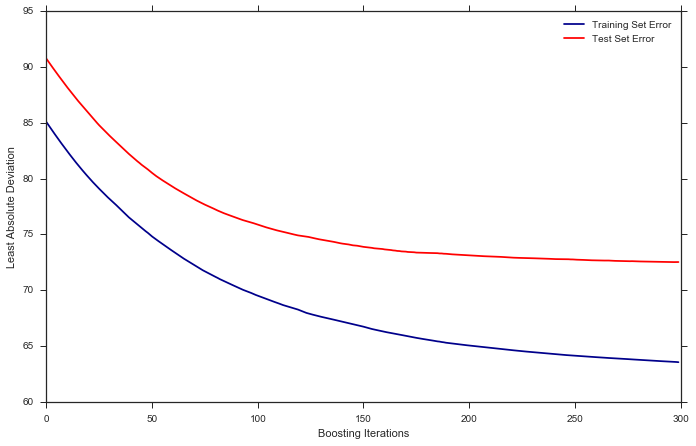

In [92]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(
        np.asarray(y_test, dtype=float), 
        np.asarray(y_pred, dtype=float))

plt.figure(figsize=(25, 7))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')


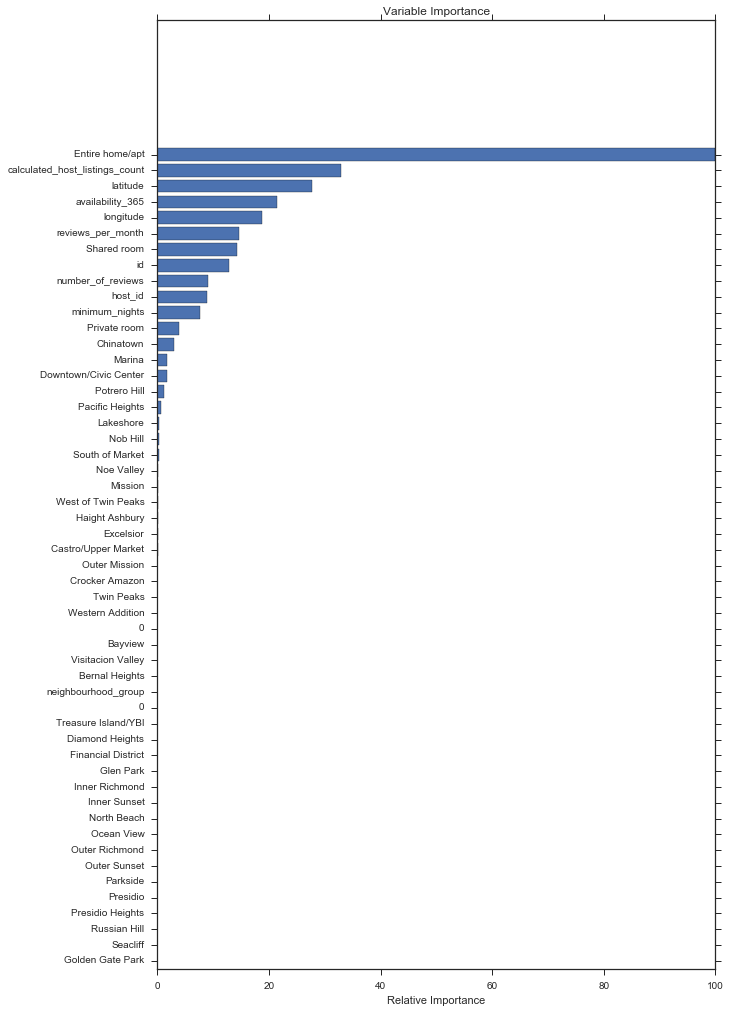

In [95]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(10,17))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')